In [1]:
import os
from functools import reduce
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pyspark
import pyspark.sql.functions as f
from matplotlib.axes import Axes
from pyspark.sql import DataFrame
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.sql.types import *

# Если hadoop_home уже настроен это трока не нужна
os.environ['HADOOP_HOME'] = r"D:\Programms\Spark\spark-2.4.4-bin-hadoop2.7"

conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

sqlContext = SQLContext(sc)

In [6]:
segment_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\EXPERIAN_CONSUMER_VIEW_SEGMENT_143"
info_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\REF_SVOD_EXPERIAN_MEASURES_MAPPING.gz"

segment_header_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\seg_col_names.txt"
info_header_file = r"D:\My_Google_Disk\University\BiQuants\segmentData\measures_mapping_col_names.txt"

segment_count = 0

In [2]:
def load_main_column_names(col_names_file_name: str) -> List:
    """
    get only important column names
    :param: colNamesFileName (str): name of file with column names
    :return: List: list of important column names
    """
    res = open(col_names_file_name, "r").read().splitlines()
    return res[3:]


def load_header_names(header_file_name: str) -> StructType:
    """
    get column names scheme from file
    :param: headerFileName: name of file with column names
    :return: column names scheme
    """
    res = [StructField(x, StringType(), True) for x in open(header_file_name, "r").read().splitlines()]
    # f = open(header_file_name, "r")
    # names = f.read().splitlines()
    # res = []
    # for x in names:
    #     res.append(StructField(x, StringType(), True))
    return StructType(res)


def load_data_frame(data_file_name: str, header_scheme: StructType) -> DataFrame:
    """
    load dataframe from file
    :param data_file_name: file name of data
    :param header_scheme: column names for chosen dataframe
    :return: loaded dataframe
    """
    # df = sqlContext.read.format('com.databricks.spark.csv').options(header='false', delimiter='|').load(
    #     data_file_name, schema=header_scheme)
    df = sqlContext.read.csv(data_file_name, header='false', schema=header_scheme, sep='|')
    return df


def get_columns_with_null(col_names: List, segment_df: DataFrame, info_df: DataFrame) -> str:
    """
    get column names that contain null values(WORK IN PROGRESS)
    :param col_names: names of column that are checked for a null values
    :param segment_df: dataframe that is checked for a null values
    :param info_df: dataframe with availiable values in column
    :return: string with all column names with null value
    """
    res = ""
    for x in col_names:
        cols_values_in_seg = segment_df.select(x).distinct().selectExpr(x + " as vals")

        availiable_cols_values = info_df.select("VALUES_SVOD_TEXT").filter(
            info_df["CONSUMER_VIEW_FIELDS"] == x).distinct().selectExpr("VALUES_SVOD_TEXT as vals")

        if cols_values_in_seg.join(availiable_cols_values, ["vals"], 'leftanti').count() == 1:
            res += x + "\n"
    return res


def get_amount_of_records_with_null(segment_df: DataFrame, column_to_check: List = None) -> int:
    """
    get Amount Of Records With Null value
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: amount of records with null
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check

    # print(segmentDF.subtract(segmentDF.dropna()).count())
    return segment_df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in columns))).count()


def get_amount_of_records_with_null_for_each_column(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get Amount Of Records With Null value for each column
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with amount of records with null for each column
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check

    col_nulls = segment_df.select([count(when(col(c).isNull(), c)).alias(c) for c in columns])
    # colNulls.show()
    return col_nulls


def get_percent_of_records_with_null_for_each_column(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get percent Of Records With Null value for each column
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with percent of records with null for each column
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check

    col_nulls_proc = segment_df.select(
        [(count(when(col(c).isNull(), c)) / segment_count).alias(c) for c in columns])
    return col_nulls_proc


def get_null_distribution_in_row(segment_df: DataFrame, column_to_check: List = None) -> DataFrame:
    """
    get null count|amount of rows with that null count dataframe
    :param segment_df: dataframe that is checked for a null values
    :param column_to_check: names of column that are checked for a null values
    :return: dataframe with null count|amount of rows with that null count
    """
    if column_to_check is None:
        columns = segment_df.columns
    else:
        columns = column_to_check

    null_count_df = segment_df.select(
        sum([segment_df[col].isNull().cast(IntegerType()) for col in columns]).alias('null_count'))

    null_count_df.show()
    return null_count_df.groupBy('null_count').count().orderBy('null_count')

In [4]:
fw = open("out.txt", "w")
col_names = load_main_column_names(segment_header_file)

segment_df = load_data_frame(segment_file, load_header_names(segment_header_file))
segment_count = segment_df.count()

info_df = load_data_frame(info_file, load_header_names(info_header_file))
nullCount = get_amount_of_records_with_null(segment_df, col_names)
get_amount_of_records_with_null_for_each_column(segment_df, col_names).coalesce(1).write.save("amount",
                                                                                              format="csv",
                                                                                              delimiter="|")
get_percent_of_records_with_null_for_each_column(segment_df, col_names).coalesce(1).write.save("percent",
                                                                                               format="csv",
                                                                                               delimiter="|")

get_null_distribution_in_row(segment_df, col_names).coalesce(1).write.save("SegNullDist", format="csv",
                                                                           delimiter="|")

res = get_columns_with_null(col_names, segment_df, info_df)
fw.write(res)

+----------+
|null_count|
+----------+
|        29|
|        35|
|         0|
|        30|
|        27|
|        27|
|        29|
|        29|
|        29|
|        27|
|         5|
|         4|
|         4|
|         5|
|         0|
|         4|
|        29|
|        29|
|        30|
|         1|
+----------+
only showing top 20 rows



In [3]:
def get_plot_vals_for_nulls_rows(file_name: str) -> (List, List):
    """
    function to get values from Nulls-RowsCount file
    :param file_name: name of Nulls-RowsCount file
    :return: nulls count and amount of records with such null count
    """
    nulls = []
    count = []
    f = open(file_name)
    for x in f.read().splitlines():
        x, y = x.split('|')
        nulls.append(int(x))
        count.append(int(y))
    return nulls, count


def show_plots_for_all_files(ax: Axes, file_names: List):
    """
    function to represent all Nulls-RowsCount files on a one plot (Very Strange function)
    :param ax: Axes to draw info on
    :param file_names: ame of Nulls-RowsCount files
    :return: None
    """
    max_nulls_len_list = []
    for name in file_names:
        nulls, count = get_plot_vals_for_nulls_rows(name)
        if len(nulls) > len(max_nulls_len_list):
            max_nulls_len_list = nulls
        ax.scatter(x=nulls, y=count, label=name)

    ax.set_xticks(np.arange(max(max_nulls_len_list) + 1))
    ax.set_xticklabels(range(0, max(max_nulls_len_list) + 1))


def get_vals_from_file(file_name: str, separator: str = "|") -> List:
    """
    get values separated by separator from a file
    :param file_name: file to get values from
    :param separator: separator in file
    :return:
    """
    res = open(file_name).read()[:-1].split(separator)
    res = list(map(float, res))
    return res


def show_plots_for_all_percent_files(ax2: Axes, col_names: List, file_names: List):
    """
    show plots for given files and column names
    :param ax2: Axes to draw on
    :param col_names: names of columns with null values
    :param file_names: The file names for which the plot is displayed
    :return:
    """
    for name in file_names:
        vals = get_vals_from_file(name)
        ax2.scatter(x=col_names, y=vals, label=name)



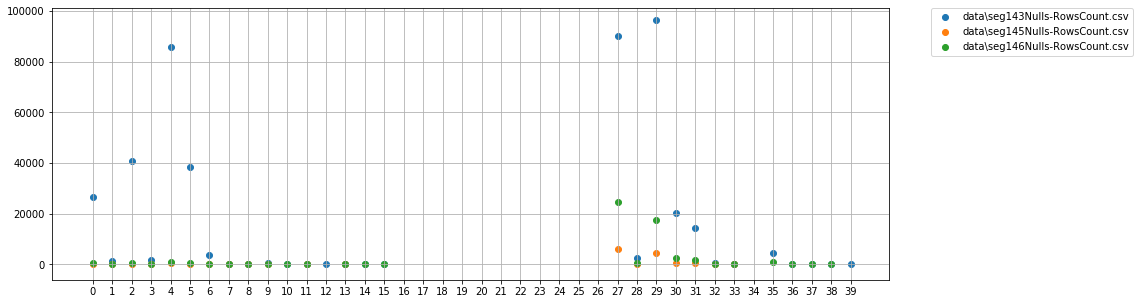

In [4]:
file_names_null_row = [r"data\seg143Nulls-RowsCount.csv",r"data\seg145Nulls-RowsCount.csv",r"data\seg146Nulls-RowsCount.csv"]
fig, ax = plt.subplots(figsize=(15,5))

show_plots_for_all_files(ax, file_names_null_row)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

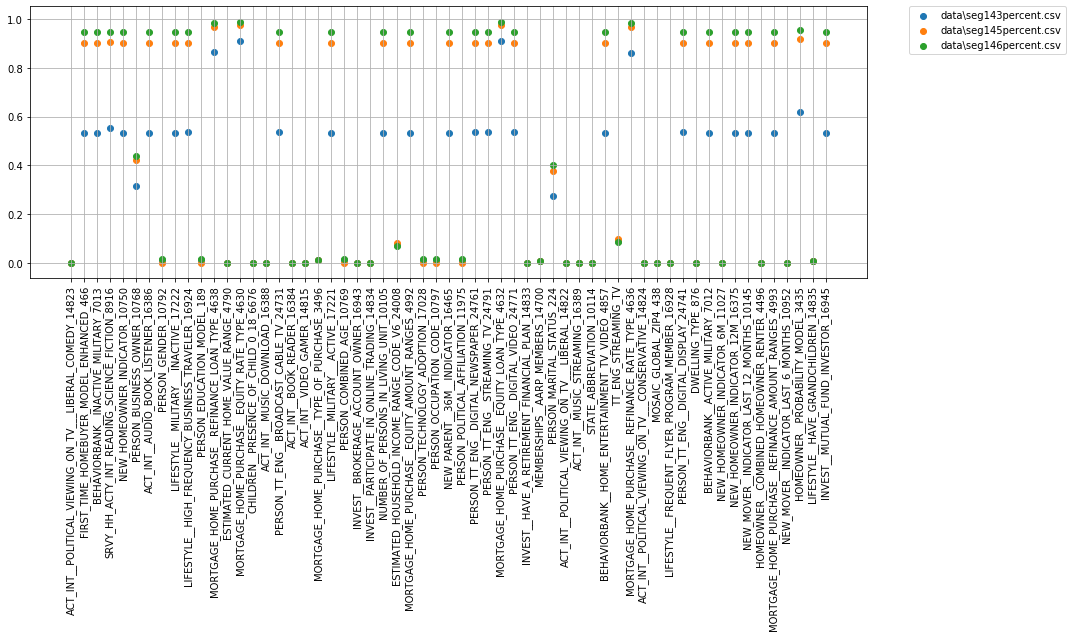

In [7]:
file_names_percent = [r"data\seg143percent.csv",r"data\seg145percent.csv",r"data\seg146percent.csv"]

col_names = load_main_column_names(segment_header_file)                
fig2, ax2 = plt.subplots(figsize=(15,5))

show_plots_for_all_percent_files(ax2, col_names, file_names_percent)
                
plt.grid()
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()